<a href="https://colab.research.google.com/github/NunezKant/iGEDS/blob/master/Global_Ecosystems_Dynamics_Initiative.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# iGEDS

Este notebook, contiene los datos originados por la iniciativa iGEDS donde:


*   Re-escalan todas las métricas a valores entre 1-5 
*   Imputan valores faltantes para algunos paises 
*   Visualiza la distribución de las métricas por país.

## Carga de datos:



In [0]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

Primeras 5 entradas de los datos originales:

In [22]:
df = pd.read_csv('https://raw.githubusercontent.com/NunezKant/iGEDS/master/iEcosystems%20v2.csv', decimal=",")
df.head()

,Pillar,Metrics,México,Argentina,Chile,Brasil,España,Worst performance (1),Frontier (5),Type
0,1 Foundational Institutions,1.01 Ease of doing business (WB),72.4,59.0,72.6,59.1,77.9,0.0,100.0,Positive
1,1 Foundational Institutions,1.02 Starting a business (WB),86.1,80.4,91.4,81.3,86.9,0.0,100.0,Positive
2,1 Foundational Institutions,1.03 Paying taxes (WB),65.8,49.3,75.3,34.4,84.7,0.0,100.0,Positive
3,1 Foundational Institutions,1.04 Resolving Insolvency (WB),70.3,40.0,60.1,50.4,79.2,0.0,100.0,Positive
4,1 Foundational Institutions,1.05 Enforcing contracts (WB),67.0,57.5,64.7,64.1,70.9,0.0,100.0,Positive


Proceso de re-escalamiento:

In [0]:
all_columns = df.columns.values.tolist()
metrics = ["Metrics","México","Argentina","Chile","Brasil","España"]
df_metrics = df[metrics]
df_pilars = df[["Pillar","Type"]]
column_names = df["Metrics"].values
df_metrics = df_metrics.T
df_metrics.columns = column_names
df_metrics.drop("Metrics", axis = 0, inplace = True)
for col,val1,val2 in zip(df_metrics.columns, df['Worst performance (1)'],df['Frontier (5)']):
  df_metrics[col] = df_metrics[col].apply(lambda x: (x-val1)/(val2-val1))

df_metrics = np.round((df_metrics*4)+1,2)

El siguiente DataFrame contiene los datos re-escalados del 1-5, sin embargo algunas entradas siguen teniendo valores faltantes, dichos valores se van a inferir con la técnica de **K-vecinos cercanos**.

In [24]:
df_metrics

,1.01 Ease of doing business (WB),1.02 Starting a business (WB),1.03 Paying taxes (WB),1.04 Resolving Insolvency (WB),1.05 Enforcing contracts (WB),1.06 Property Rights (IEF),1.07 Government Integrity (IEF),1.08 Labor Freedom (IEF),1.09 Trade freedom (IEF),1.10 Corruption Perceptions Index (TI),2.01a Percentage of adults with a doctoral or equivalent level of education (OECD),2.01b Skillset of graduates (GCI 4.0),2.01c Ease of finding skilled employees (GCI 4.0),2.01d Researchers/Professionals engaged in R&D per million population (GII),"2.01e STEM Graduates per capita (OECD) - Natural sciences, mathematics and statistics",2.02a R&D expenditure as a % GDP (UNESCO),2.02b R&D expenditure in '000 current PPP$ (UNESCO),2.02c Public R&D Expenditure as % of total R&D expenditure (UNESCO),2.02d Business Expenditure as % of total R&D expenditure (UNESCO),2.03a ICT Adoption (GCI 4.0),2.03b Production Process Sophistication (GCI),2.03c Availability of latest technologies (GCI),2.03d ICT access (GII),2.04a Government procurement of advanced technology (GCI),2.04b University-industry research collaborations (GII),"2.04c Trade, Competition & Market scale (GII)",2.05a Research institutions prominence (GCI 4.0),2.05b Graduates in science & engineering (%) (GII),3.01a Entrepreneurship perceived capabilities (GEM),3.01b % school grads in tertiary education (GII),3.02a VC investment,3.02b Financing of SME's (GCI 4.0),3.02c Venture Capital Availability (GCI 4.0),3.02d Ease of Credit (GII),3.02e VC deals (GII),3.02f Venture Capital Deal Volume,3.03a Logistics performance (World Bank),3.03b Electricity (GCI),3.03c ICT Adoption (GCI),3.03d Number of internet users (UN),3.04a Buyer sophistication (GCI 4.0),3.04b Domestic Market Scale (GII),3.05a Entrepreneurial intentions (GEM),3.05b Fear of failure (GEM),3.05c Entrepreneurship as a Good Career choice (GEM),3.05d High Status to Successful Entrepreneurs (GEM),3.05e Business Freedom (Heritage Foundation),3.05f Attitudes towards Entrepreneurial Risk (GCI 4.0),4.01 State of cluster development (GCI 4.0),4.02 Country capacity to attract and retain talent,5.01 GDP per capita,5.02 Social Progress Index,5.03 Inclusive Development Index,5.04 Population below international poverty line (SDG 1 - No poverty),5.05 Prevalence of undernourishment (SDG 2 - Zero Hunger),5.06 Annual growth rate of real GDP per capita (SDG 8 - Decent Jobs and Economic Growth),5.07 Unemployment rate of population 15 years of age and older (SDG 8 - Decent Jobs and Economic Growth),"5.08 Carbon dioxide emissions per unit of GDP (SDG 9 - Industry, Innovation and Infrastructure)",5.09 Proportion of urban population living in slums (SDG 11 - Sustainable Cities and Communities),5.10 Annual population-weighted average mean concentration of fine suspended particles of less than 2.5 microns in diameter (SDG 11 - Sustainable Cities and Communities),5.11 Domestic material consumption per capita (SDG 12 - Responsible Consumption and Production)
México,3.90,4.44,3.63,3.81,3.68,3.33,2.47,3.34,4.50,2.12,1.00,3.06,3.12,1.11,3.10,2.30,2.62,2.3,3.00,3.20,3.20,3.67,3.20,2.40,2.75,4.18,2.19,2.84,4.04,2.19,1.52,2.82,2.53,4.6,1.04,1.29,3.08,4.82,3.20,3.41,2.76,4.10,1.78,2.21,3.49,3.62,3.68,3.04,3.19,2.67,1.46,3.82,3.08,1.19,1.11,3.34,4.72,4.33,4.52,4.32,1.71
Argentina,3.36,4.22,2.97,2.60,3.30,3.02,2.99,2.86,3.77,2.60,NaN,3.12,3.12,1.59,1.00,2.47,1.71,2.2,4.07,3.32,2.87,3.13,3.92,2.20,2.50,3.45,1.79,1.80,2.34,3.81,1.08,2.08,1.88,3.2,1.08,1.02,2.93,4.79,3.32,3.81,2.66,3.69,1.67,4.06,2.99,2.63,3.41,3.03,2.63,2.53,1.55,4.07,3.09,1.02,1.11,3.58,3.94,4.20,4.58,4.71,2.03
Chile,3.90,4.66,4.01,3.40,3.59,3.80,3.94,3.59,4.56,3.68,NaN,3.39,3.58,1.24,3.35,1.87,1.21,2.2,1.27,3.52,3.27,4.07,3.91,2.20,2.75,3.93,1.63,2.28,4.42,3.89,1.88,3.09,2.84,3.2,1.12,1.11,3.28,5.00,3.52,4.19,2.98,3.43,4.71,1.00,3.85,4.01,4.00,3.16,2.82,3.40,1.76,4.20,3.29,1.05,1.06,3.32,4.16,4.29,4.84,4.28,5.00
Brasil,3.36,4.25,2.38,3.02,3.56,3.29,2.82,2.98,3.71,2.40,1.21,2.47,2.59,1.42,1.45,4.87,6.94,

Total de valores faltantes:
* Brasil tiene 2 valores faltantes, por 1 de chile y de argentina

In [25]:
df.isnull().sum()

Pillar                   0
Metrics                  0
México                   0
Argentina                1
Chile                    1
Brasil                   2
España                   0
Worst performance (1)    0
Frontier (5)             0
Type                     0
dtype: int64

Se van a rellenar los valores faltantes con la media de los 3 vecinos más cercanos al país, la distancia entre los países la dictan los valores que tienen en cada métrica.

In [19]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=3)
var = imputer.fit_transform(df_metrics)
df_imputed = pd.DataFrame(var)
df_imputed.columns = column_names
df_imputed.index = df_metrics.index
df_imputed.head()

,1.01 Ease of doing business (WB),1.02 Starting a business (WB),1.03 Paying taxes (WB),1.04 Resolving Insolvency (WB),1.05 Enforcing contracts (WB),1.06 Property Rights (IEF),1.07 Government Integrity (IEF),1.08 Labor Freedom (IEF),1.09 Trade freedom (IEF),1.10 Corruption Perceptions Index (TI),2.01a Percentage of adults with a doctoral or equivalent level of education (OECD),2.01b Skillset of graduates (GCI 4.0),2.01c Ease of finding skilled employees (GCI 4.0),2.01d Researchers/Professionals engaged in R&D per million population (GII),"2.01e STEM Graduates per capita (OECD) - Natural sciences, mathematics and statistics",2.02a R&D expenditure as a % GDP (UNESCO),2.02b R&D expenditure in '000 current PPP$ (UNESCO),2.02c Public R&D Expenditure as % of total R&D expenditure (UNESCO),2.02d Business Expenditure as % of total R&D expenditure (UNESCO),2.03a ICT Adoption (GCI 4.0),2.03b Production Process Sophistication (GCI),2.03c Availability of latest technologies (GCI),2.03d ICT access (GII),2.04a Government procurement of advanced technology (GCI),2.04b University-industry research collaborations (GII),"2.04c Trade, Competition & Market scale (GII)",2.05a Research institutions prominence (GCI 4.0),2.05b Graduates in science & engineering (%) (GII),3.01a Entrepreneurship perceived capabilities (GEM),3.01b % school grads in tertiary education (GII),3.02a VC investment,3.02b Financing of SME's (GCI 4.0),3.02c Venture Capital Availability (GCI 4.0),3.02d Ease of Credit (GII),3.02e VC deals (GII),3.02f Venture Capital Deal Volume,3.03a Logistics performance (World Bank),3.03b Electricity (GCI),3.03c ICT Adoption (GCI),3.03d Number of internet users (UN),3.04a Buyer sophistication (GCI 4.0),3.04b Domestic Market Scale (GII),3.05a Entrepreneurial intentions (GEM),3.05b Fear of failure (GEM),3.05c Entrepreneurship as a Good Career choice (GEM),3.05d High Status to Successful Entrepreneurs (GEM),3.05e Business Freedom (Heritage Foundation),3.05f Attitudes towards Entrepreneurial Risk (GCI 4.0),4.01 State of cluster development (GCI 4.0),4.02 Country capacity to attract and retain talent,5.01 GDP per capita,5.02 Social Progress Index,5.03 Inclusive Development Index,5.04 Population below international poverty line (SDG 1 - No poverty),5.05 Prevalence of undernourishment (SDG 2 - Zero Hunger),5.06 Annual growth rate of real GDP per capita (SDG 8 - Decent Jobs and Economic Growth),5.07 Unemployment rate of population 15 years of age and older (SDG 8 - Decent Jobs and Economic Growth),"5.08 Carbon dioxide emissions per unit of GDP (SDG 9 - Industry, Innovation and Infrastructure)",5.09 Proportion of urban population living in slums (SDG 11 - Sustainable Cities and Communities),5.10 Annual population-weighted average mean concentration of fine suspended particles of less than 2.5 microns in diameter (SDG 11 - Sustainable Cities and Communities),5.11 Domestic material consumption per capita (SDG 12 - Responsible Consumption and Production)
México,3.90,4.44,3.63,3.81,3.68,3.33,2.47,3.34,4.50,2.12,1.000000,3.06,3.12,1.11,3.10,2.30,2.62,2.300000,3.00,3.20,3.20,3.67,3.20,2.40,2.75,4.18,2.19,2.84,4.04,2.19,1.52,2.82,2.53,4.6,1.04,1.29,3.08,4.82,3.20,3.41,2.76,4.10,1.78,2.21,3.49,3.62,3.68,3.04,3.19,2.67,1.46,3.82,3.08,1.19,1.11,3.34,4.72,4.33,4.52,4.32,1.71
Argentina,3.36,4.22,2.97,2.60,3.30,3.02,2.99,2.86,3.77,2.60,1.343333,3.12,3.12,1.59,1.00,2.47,1.71,2.200000,4.07,3.32,2.87,3.13,3.92,2.20,2.50,3.45,1.79,1.80,2.34,3.81,1.08,2.08,1.88,3.2,1.08,1.02,2.93,4.79,3.32,3.81,2.66,3.69,1.67,4.06,2.99,2.63,3.41,3.03,2.63,2.53,1.55,4.07,3.09,1.02,1.11,3.58,3.94,4.20,4.58,4.71,2.03
Chile,3.90,4.66,4.01,3.40,3.59,3.80,3.94,3.59,4.56,3.68,1.343333,3.39,3.58,1.24,3.35,1.87,1.21,2.200000,1.27,3.52,3.27,4.07,3.91,2.20,2.75,3.93,1.63,2.28,4.42,3.89,1.88,3.09,2.84,3.2,1.12,1.11,3.28,5.00,3.52,4.19,2.98,3.43,4.71,1.00,3.85,4.01,4.00,3.16,2.82,3.40,1.76,4.20,3.29,1.05,1.06,3.32,4.16,4.29,4.84,4.28,5.00
Brasil,3.36,4.25,2.38,3.02,3.56,3.29,2.82,2.98,3.71,2.40,1.2100

Se concatenan los nombres de los pilares y del tipo de relación que tiene la variable, este df servirá para obtener las correlaciones.

In [149]:
df_concat = pd.concat([df_pilars,df_imputed.T.reset_index()], axis = 1).rename(columns={'index':'Metrics'})
df_concat

,Pillar,Type,Metrics,México,Argentina,Chile,Brasil,España
0,1 Foundational Institutions,Positive,1.01 Ease of doing business (WB),3.90,3.36,3.90,3.36,4.12
1,1 Foundational Institutions,Positive,1.02 Starting a business (WB),4.44,4.22,4.66,4.25,4.48
2,1 Foundational Institutions,Positive,1.03 Paying taxes (WB),3.63,2.97,4.01,2.38,4.39
3,1 Foundational Institutions,Positive,1.04 Resolving Insolvency (WB),3.81,2.60,3.40,3.02,4.17
4,1 Foundational Institutions,Positive,1.05 Enforcing contracts (WB),3.68,3.30,3.59,3.56,3.84
...,...,...,...,...,...,...,...,...
56,5 Impact,Negative,5.07 Unemployment rate of population 15 years ...,4.72,3.94,4.16,3.26,2.57
57,5 Impact,Negative,5.08 Carbon dioxide emissions per unit of GDP ...,4.33,4.20,4.29,4.60,4.56
58,5 Impact,Negative,5.09 Proportion of urban population living in ...,4.52,4.58,4.84,4.51,4.90
59,5 Impact,Negative,5.10 Annual population-weighted average mean c...,4.32,4.71,4.28,4.73,4.82


Para corregir aquellas entradas que son de tipo 'Negativo' lo que se me ocurrío hacer, es sacar el complemento del valor respecto al máximo (obtener el valor absoluto de la resta del número menos el máximo) y sumarle 1 para que se encuentre en la escala de 1-5, por ejemplo, si una métrica es negativa y tiene un valor de **4.5** siguendo la formula:

Encontramos su complemento respecto al máximo: `abs(5-4.5) = 0.5`

Le sumamos 1 para que entre a nuestra escala: `0.5 + 1 = 1.5`

Siguendo ésta transformación, si en una métrica negativa un país tiene 5:

`5-5 + 1 = 1` lo deja en 1.

Si un país tiene 1:

`abs(1-5) + 1 = 5 `



In [0]:
df_concat.loc[df_concat['Type']=='Negative',["México","Argentina","Chile","Brasil","España"]] = df_concat.loc[df_concat['Type']=='Negative',["México","Argentina","Chile","Brasil","España"]].apply(lambda x: np.abs(x-5)+1)

In [151]:
df_concat.drop('Type',axis=1,inplace = True)
df_concat

,Pillar,Metrics,México,Argentina,Chile,Brasil,España
0,1 Foundational Institutions,1.01 Ease of doing business (WB),3.90,3.36,3.90,3.36,4.12
1,1 Foundational Institutions,1.02 Starting a business (WB),4.44,4.22,4.66,4.25,4.48
2,1 Foundational Institutions,1.03 Paying taxes (WB),3.63,2.97,4.01,2.38,4.39
3,1 Foundational Institutions,1.04 Resolving Insolvency (WB),3.81,2.60,3.40,3.02,4.17
4,1 Foundational Institutions,1.05 Enforcing contracts (WB),3.68,3.30,3.59,3.56,3.84
...,...,...,...,...,...,...,...
56,5 Impact,5.07 Unemployment rate of population 15 years ...,1.28,2.06,1.84,2.74,3.43
57,5 Impact,5.08 Carbon dioxide emissions per unit of GDP ...,1.67,1.80,1.71,1.40,1.44
58,5 Impact,5.09 Proportion of urban population living in ...,1.48,1.42,1.16,1.49,1.10
59,5 Impact,5.10 Annual population-weighted average mean c...,1.68,1.29,1.72,1.27,1.18


Por último se obtiene el **tidy** dataframe, el cuál contiene:
una carácteristica por columna y una observación por fila.

In [152]:
final_df = pd.melt(df_concat,id_vars=['Pillar','Metrics'],value_vars=["México","Argentina","Chile","Brasil","España"],value_name="Value",var_name="Country")
final_df

,Pillar,Metrics,Country,Value
0,1 Foundational Institutions,1.01 Ease of doing business (WB),México,3.90
1,1 Foundational Institutions,1.02 Starting a business (WB),México,4.44
2,1 Foundational Institutions,1.03 Paying taxes (WB),México,3.63
3,1 Foundational Institutions,1.04 Resolving Insolvency (WB),México,3.81
4,1 Foundational Institutions,1.05 Enforcing contracts (WB),México,3.68
...,...,...,...,...
300,5 Impact,5.07 Unemployment rate of population 15 years ...,España,3.43
301,5 Impact,5.08 Carbon dioxide emissions per unit of GDP ...,España,1.44
302,5 Impact,5.09 Proportion of urban population living in ...,España,1.10
303,5 Impact,5.10 Annual population-weighted average mean c...,España,1.18


Ya tenemos los datos limpios, re-escalados, sin valores faltantes y con todas las métricas en 'positivo' ahora podemos empezar a hacer visualizaciones y obtener información del set de datos.

vamos a obtener la media por pilar de cada país para obtener la matriz de correlación.

In [0]:
corr =df_concat.groupby('Pillar').mean().T.corr()

Nos interesa como se relacionan las métricas con las variables de salida:


*   4 Comparative Advantage
*   5 Impact



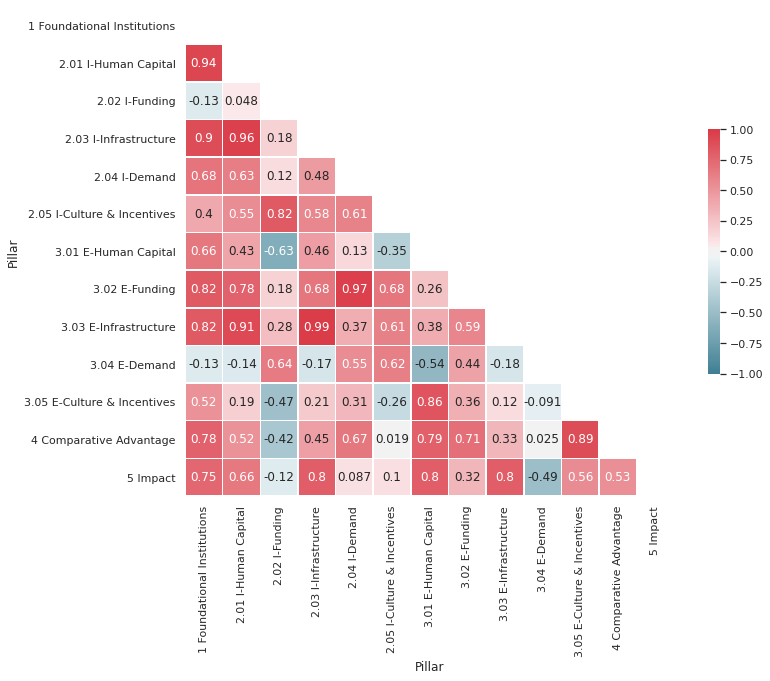

In [154]:
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap,annot=True,vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [0]:
#@title Función de spider plot
def make_spider_comparison(df,country_name1,country_name2):
  from math import pi
  categories=list(df)
  N = len(categories)
  
  # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
  angles = [n / float(N) * 2 * pi for n in range(N)]
  angles += angles[:1]
  fig = plt.figure(figsize=(8, 8))
  # Initialise the spider plot
  ax = plt.subplot(111, polar=True)
  
  # If you want the first axis to be on top:
  ax.set_theta_offset(pi / 2)
  ax.set_theta_direction(-1)
  # Draw one axe per variable + add labels labels yet
  plt.xticks(angles[:-1], categories )
  # Draw ylabels
  ax.set_rlabel_position(0)
  plt.yticks([1,2,3,4,5], ["1","2","3","4",""], color="grey", size=13)
  plt.ylim(0,5)
  
  
  # ------- PART 2: Add plots
  
  # Plot each individual = each line of the data
  # I don't do a loop, because plotting more than 3 groups makes the chart unreadable
  
  # Ind1
  values=df.loc[country_name1].values.flatten().tolist()
  values += values[:1]
  ax.plot(angles, values, linewidth=1, linestyle='solid', label=country_name1)
  ax.fill(angles, values, 'b', alpha=0.1)
  
  # Ind2
  values=df.loc[country_name2].values.flatten().tolist()
  values += values[:1]
  ax.plot(angles, values, linewidth=1, linestyle='solid', label=country_name2)
  ax.fill(angles, values, 'r', alpha=0.1)
  
  # Add legend
  plt.legend( bbox_to_anchor=(0.05, 0.25))
  plt.tight_layout()

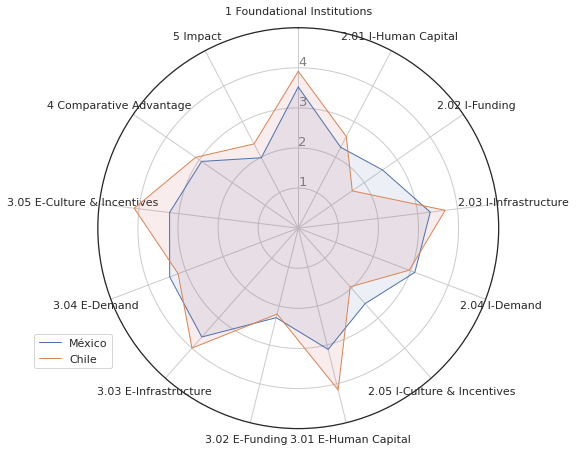

In [167]:
make_spider_comparison(df_concat.groupby('Pillar').mean().T,'México','Chile')

Las siguientes dos entradas tienen un error:



*   El valor de Brasil para 2.02b es mayor que el Frontier 
*   El valor de España para 2.02c es mayor que el Frontier



In [165]:
df_concat.loc[df_concat['Brasil']>5]


,Pillar,Metrics,México,Argentina,Chile,Brasil,España
16,2.02 I-Funding,2.02b R&D expenditure in '000 current PPP$ (UN...,2.62,1.71,1.21,6.94,4.17


In [166]:
df_concat.loc[df_concat['España']>5]

,Pillar,Metrics,México,Argentina,Chile,Brasil,España
17,2.02 I-Funding,2.02c Public R&D Expenditure as % of total R&D...,2.3,2.2,2.2,3.966667,7.4
